## Control Variables
- ROBOT_RADIUS = 0.25
- RESOLUTION = 0.25
- BO_INITIAL_SAMPLES = 30
- BO_OPT_SAMPLES = 20
----
- Vary Num of Agent: 5/10/15
- Vary Objective Function
- Vary Scheme 
- Try another environment!!!
- Vary Region Size: 4/8/16 (maybe not)
- Vary Resolution: 0.1, 0.25, 0.5 (maybe not)

In [1]:
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.bo2VoronoiDirected as bo2VoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy
import time
import os
import itertools

from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Constant
np.random.seed(9)
NUM_SAMPLE = 50

COLOUR = itertools.cycle(['#00FFFF', '#6495ED', '#89CFF0', '#0000FF', '#7393B3', '#088F8F', 
                          '#0096FF', '#0047AB', '#00FFFF', '#00008B', '#6F8FAF',
                          '#1434A4', '#7DF9FF', '#6082B6', '#00A36C', '#5D3FD3',
                          '#ADD8E6'])

### Helper Functions

In [2]:
# Updated Get Coverage, take into account of obs now
def getCoverage(exp, G, directed = False, save_fig_path = None):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,exp.image.shape[1])
    plt.ylim(0,exp.image.shape[0])
    count = 0
    
    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)
    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    obs_black = np.count_nonzero(X_reshape == 0)
#     print("Obstacle Black", obs_black)
    
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']*exp.ROBOT_RADIUS
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']*exp.ROBOT_RADIUS
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    
                print_colour = 'blue' if save_fig_path != None else 'black'
                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = print_colour )
                plt.gca().add_patch(rect)
                count +=1

    ax.axis('off')
    if save_fig_path != None:
        plt.savefig(save_fig_path)

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
#     print("Black px", black, "White px", white)
    percentage = (black-obs_black)/(white+black-obs_black)
#     print("U2", percentage)
    return percentage

In [3]:
def showGirdSolution(paths=None, exp=None, save_fig_path=None):
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)

    for agent, path in enumerate(paths):
        colour = next(colors)
        for t, pos in enumerate(path):
            if t == 0:
                continue
            past_pos = np.array(list(path[t-1]))
            pos = np.array(list(pos))
            plt.plot([past_pos[1],pos[1]], [past_pos[0],pos[0]], alpha=0.9, color = colour, linewidth=2)
            
            if np.all(pos == exp.end_locations[agent]):
                break
                
    for p in exp.start_locations:
        plt.scatter(p[1], p[0], s=80, facecolors='none', edgecolors='r')
    for p in exp.end_locations:
        plt.scatter(p[1], p[0], s=80, facecolors='r', edgecolors='r')
    
    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)
    return fig

In [4]:
def showVorSolution(
    paths = None,
    graph = None, 
    exp = None, 
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    for agent, path in enumerate(paths):
        colour = next(colors)
        for t, n in enumerate(path):
            if t == 0:
                continue
            past_n = path[t-1]
            
            p2 = graph.nodes[n]['position']
            p1 = graph.nodes[past_n]['position']
            
            plt.plot([p1.y,p2.y], [p1.x, p2.x], alpha=0.9, color = colour, linewidth=2)
        if np.all(graph.nodes[n]['position'] == exp.end_locations[agent]):
            break

    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    
    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)
    return fig

In [5]:
def showVorDirSolution(
    result_graph, 
    paths,
    exp,
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    assigned = {}
    scaler = 0.2
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
            head_width = 0.1 if mag < 0.2 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
        
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [6]:
def showVorDirSolutionPath(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [7]:
def showVorDirSolutionAcc(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None, 
    exp=None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path
        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
                
    #draw all other arrow
    scaler = 0.8
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
            head_width = 0.1 if mag < 0.5 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [8]:
def getWaiting(paths=None, exp=None, grid = False):
    if grid:
        end = [(elem[0], elem[1])for elem in exp.end_locations]
        count = 0
        for a, path in enumerate(paths):
            last_step = None
            for t, step in enumerate(path):
                initialised = not np.any(last_step == None)
                not_destination = (step[0], step[1]) not in end
                if initialised and not_destination and step == last_step: 
                    count += 1
                last_step = step
        count /= exp.NUM_OF_AGENT     
        return count
    
    count = 0
    for a, path in enumerate(paths):
        last_step = None
        for t, step in enumerate(path):
            initialised = not np.any(last_step == None)
            not_destination = step not in exp.end_locations
            if step not in exp.end_nodes:
                count += 1
            last_step = step
    count /= exp.NUM_OF_AGENT     
    return count

In [9]:
results = []

### Experiment
- Vary map with same level of obstacle density
- Vary number of agent
- Vary Objective
- Vary Dataset

In [10]:
# mapp ='den101d'

# scene = "./input/same_density/"+ mapp +'/dataset/'+str(4)+'_'+ mapp + ".scen"
# scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
# exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= 'Both', num_agent=12)
# exp.setParameters()

In [11]:
# test= [[None],[None]]
# exp.getWaiting(paths=test)

Successfully created the directory ./data/same_density/den101d/12-agent/objective-Distance/Dataset5/ 
Set Hyper Parameters, solving for 12 agents

Cannot find solution

num acquisition: 1, time elapsed: 40.98s
num acquisition: 2, time elapsed: 109.93s
num acquisition: 3, time elapsed: 160.90s
num acquisition: 4, time elapsed: 161.86s
num acquisition: 5, time elapsed: 225.78s
num acquisition: 6, time elapsed: 279.14s
num acquisition: 7, time elapsed: 330.81s
num acquisition: 8, time elapsed: 422.87s
num acquisition: 9, time elapsed: 453.66s
num acquisition: 10, time elapsed: 454.63s
num acquisition: 11, time elapsed: 455.63s
num acquisition: 12, time elapsed: 496.15s
num acquisition: 13, time elapsed: 497.25s
num acquisition: 14, time elapsed: 606.71s
num acquisition: 15, time elapsed: 629.69s
num acquisition: 16, time elapsed: 665.01s
num acquisition: 17, time elapsed: 689.45s
num acquisition: 18, time elapsed: 708.15s
num acquisition: 19, time elapsed: 708.94s
num acquisition: 20, tim

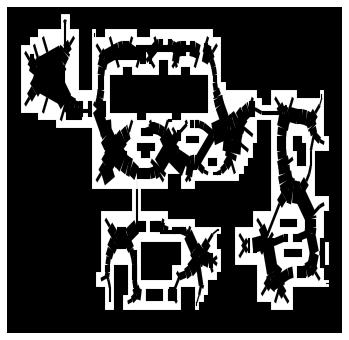

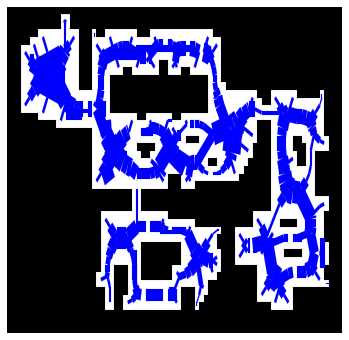

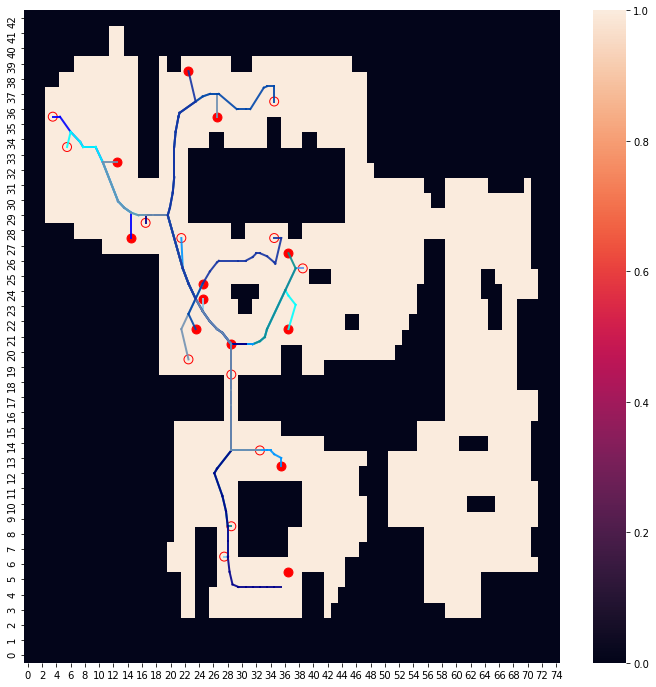

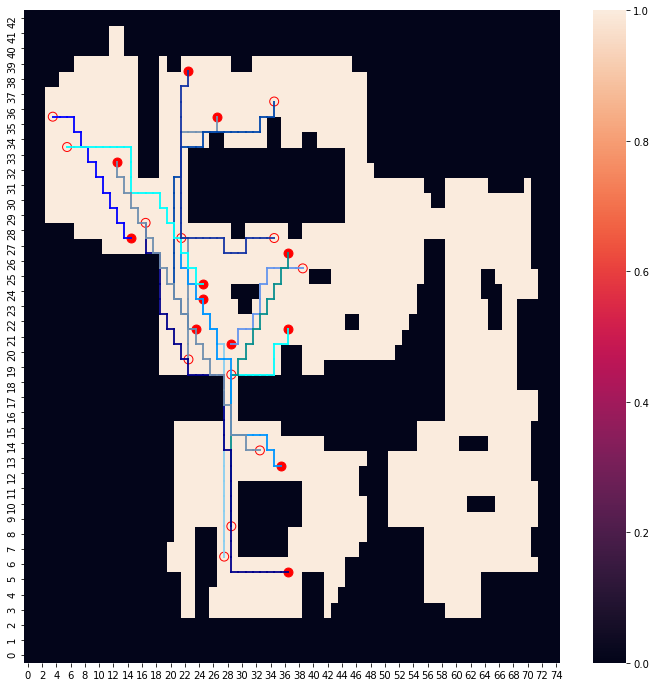

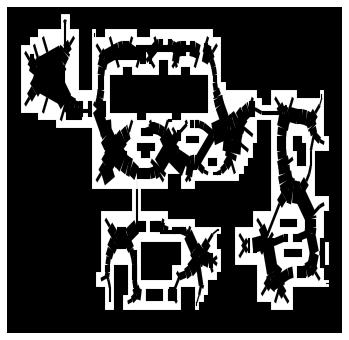

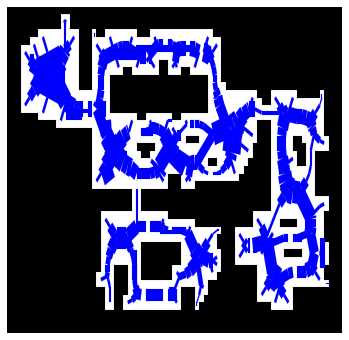

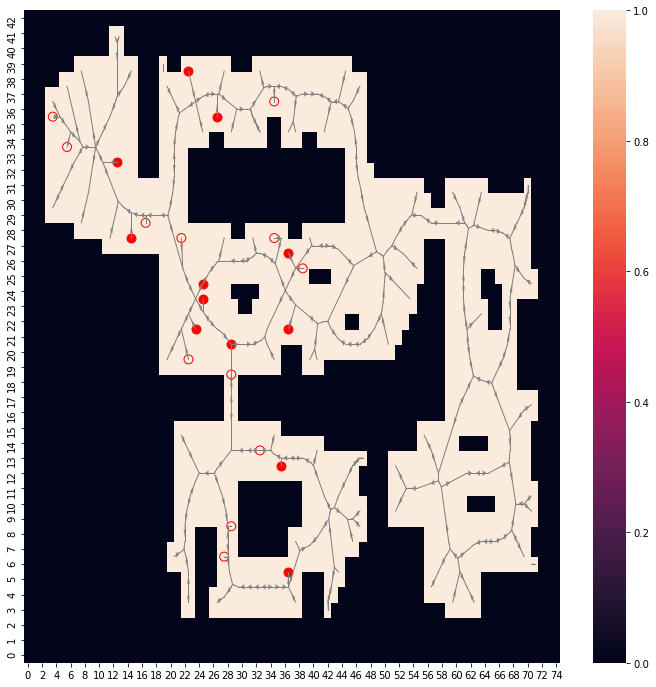

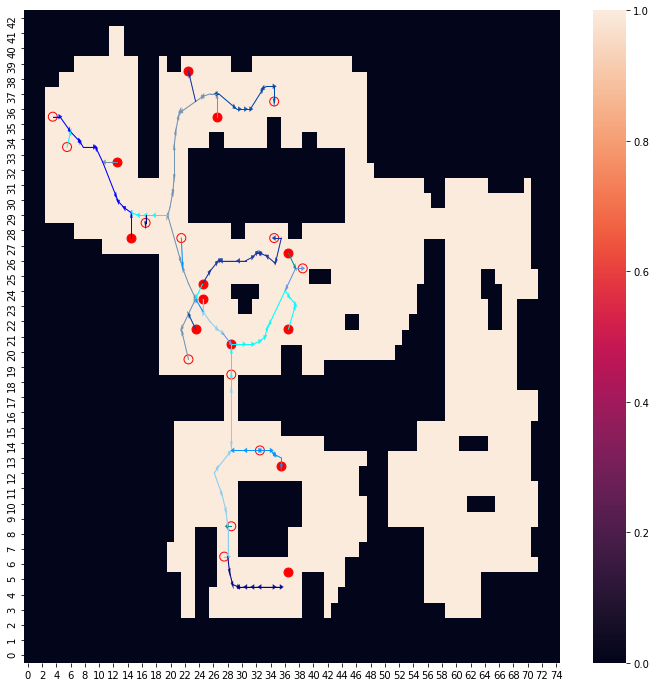

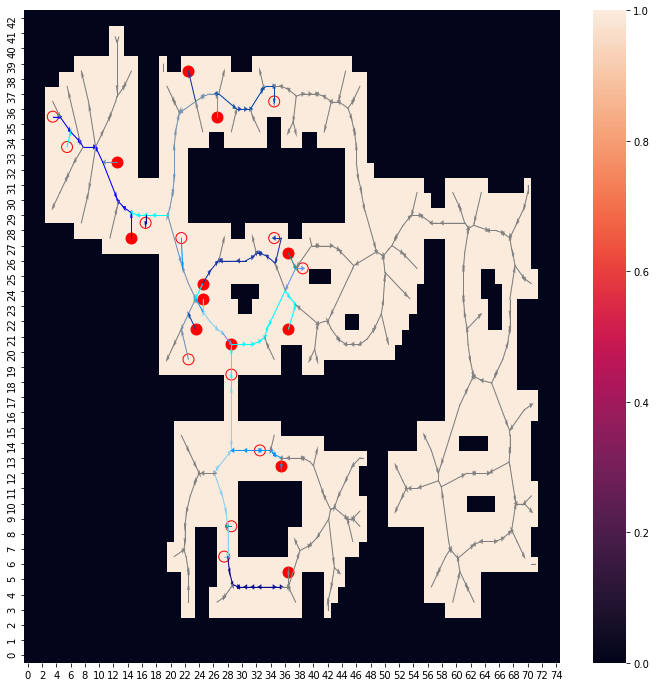

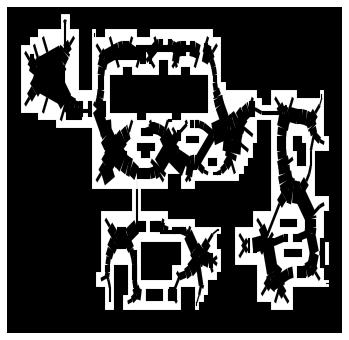

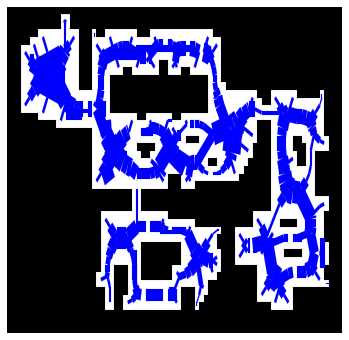

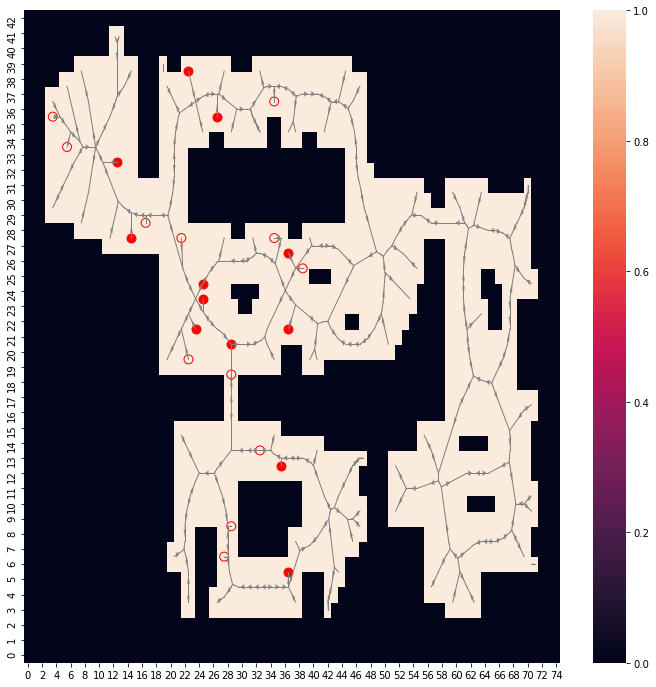

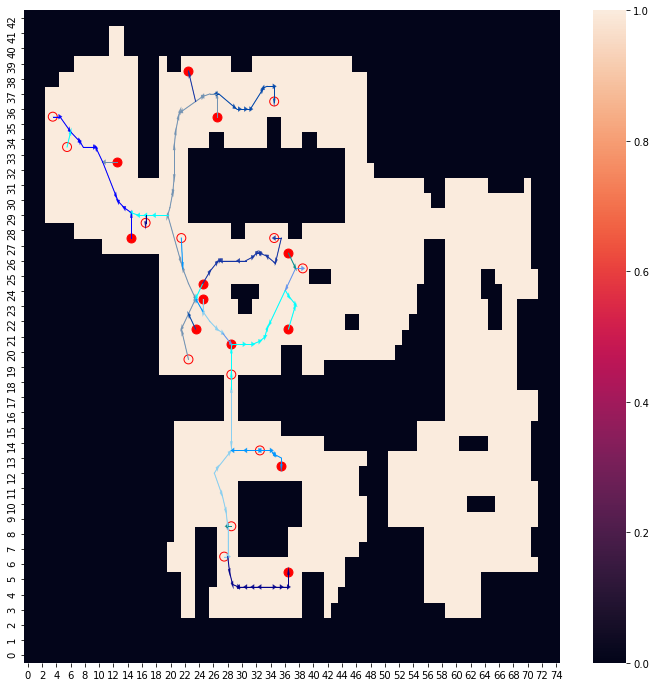

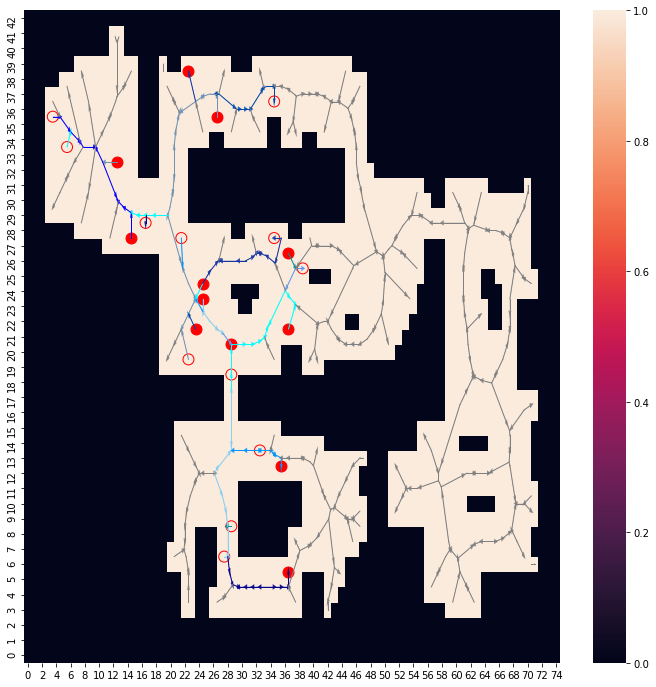

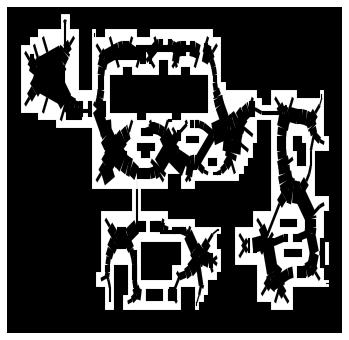

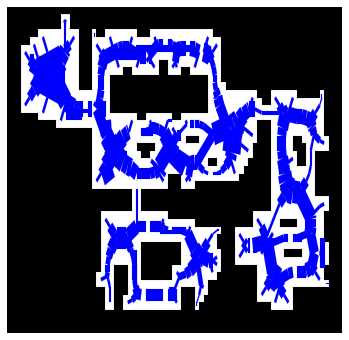

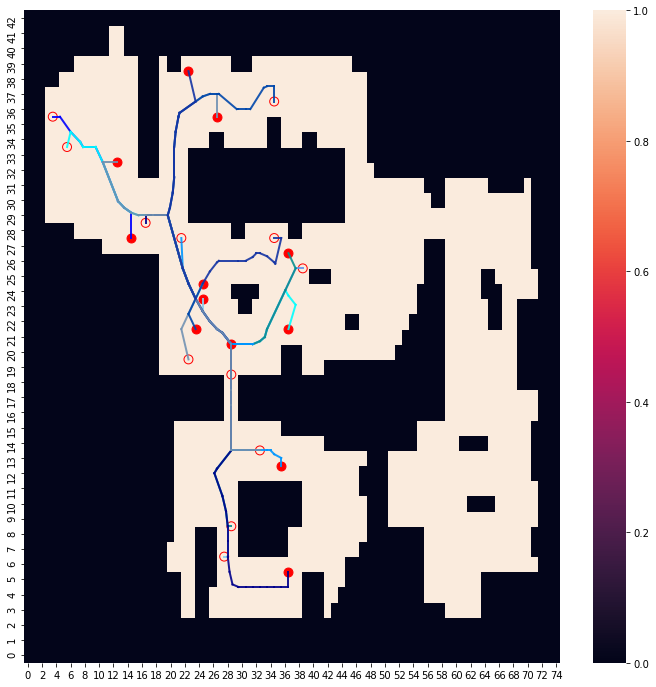

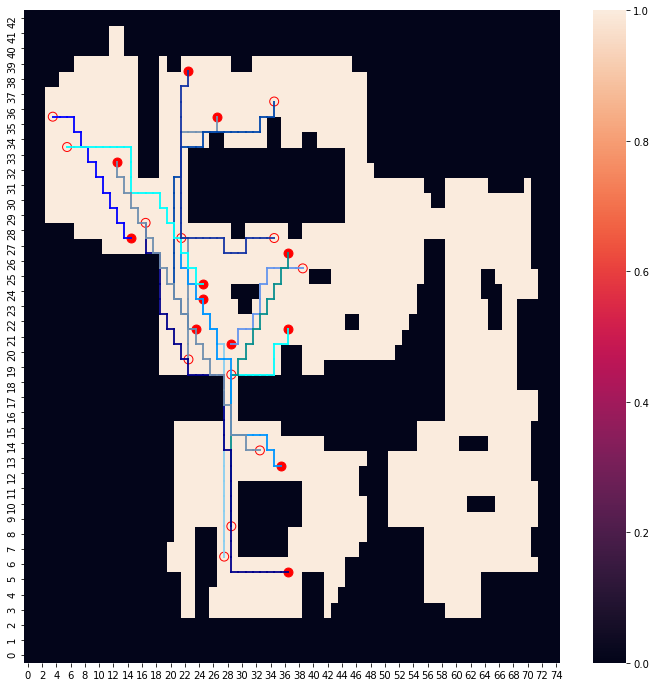

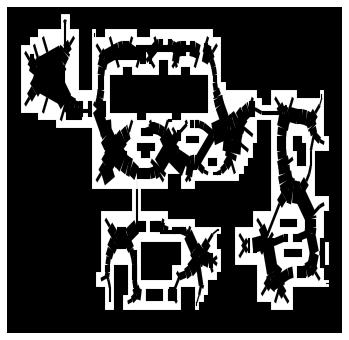

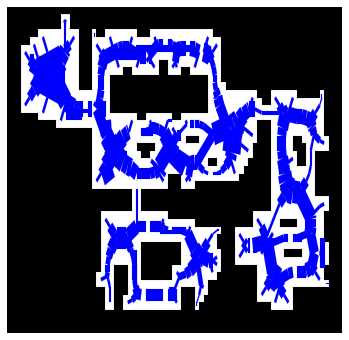

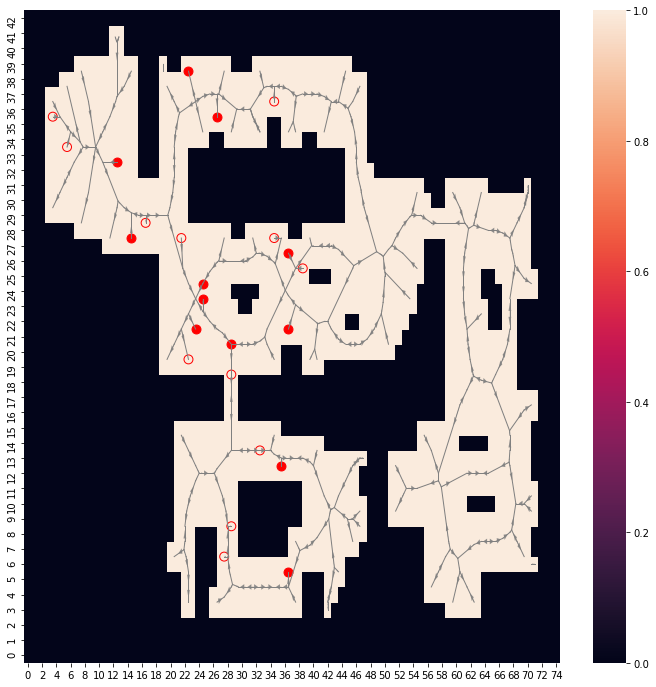

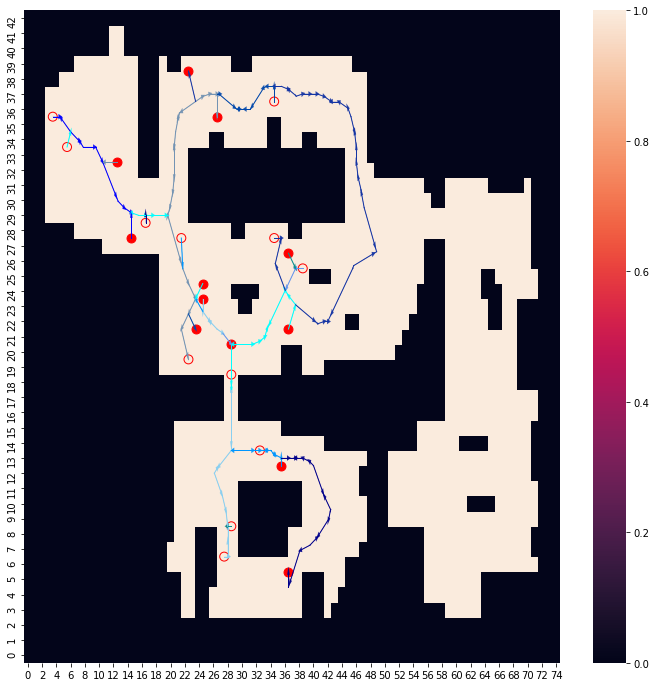

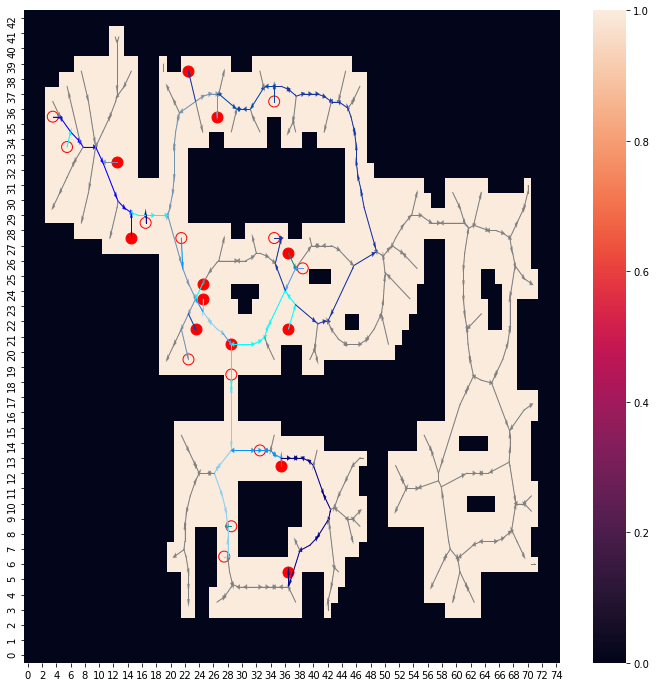

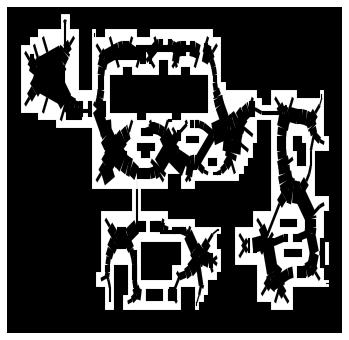

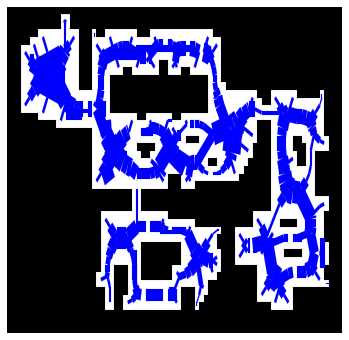

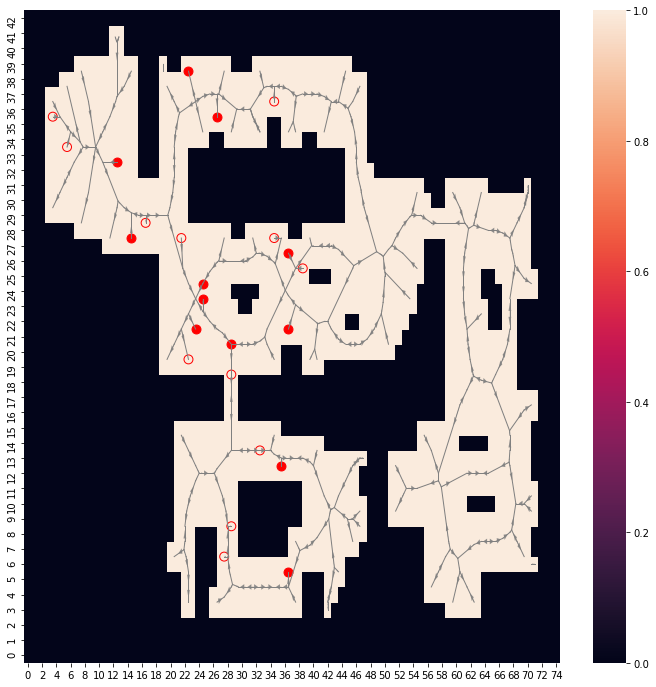

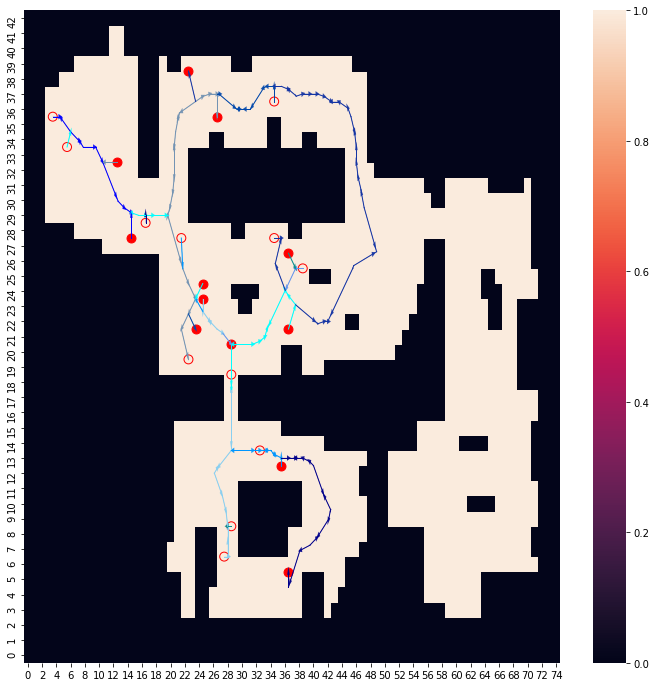

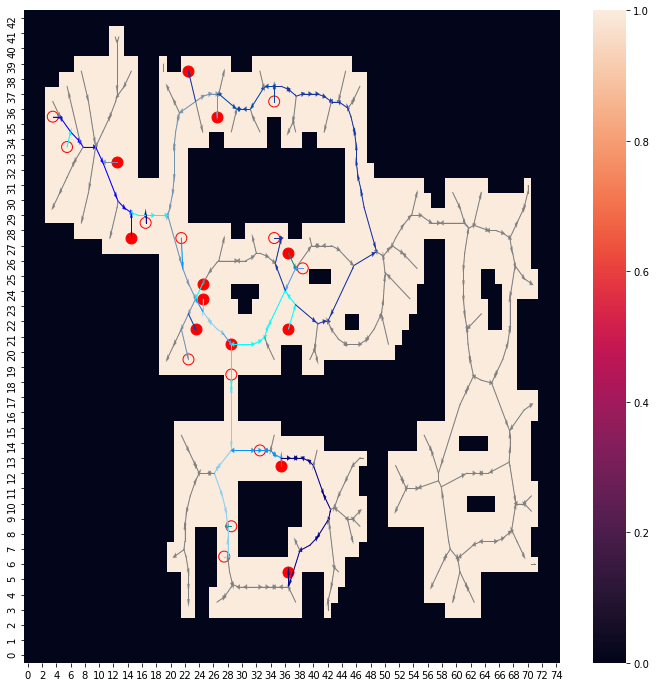

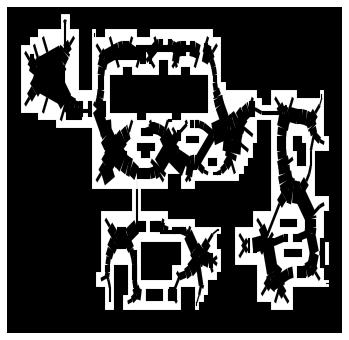

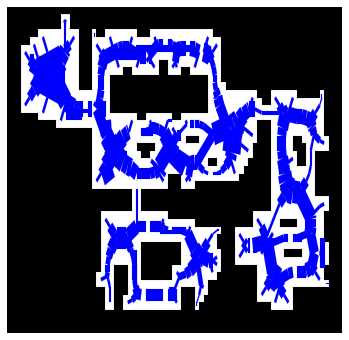

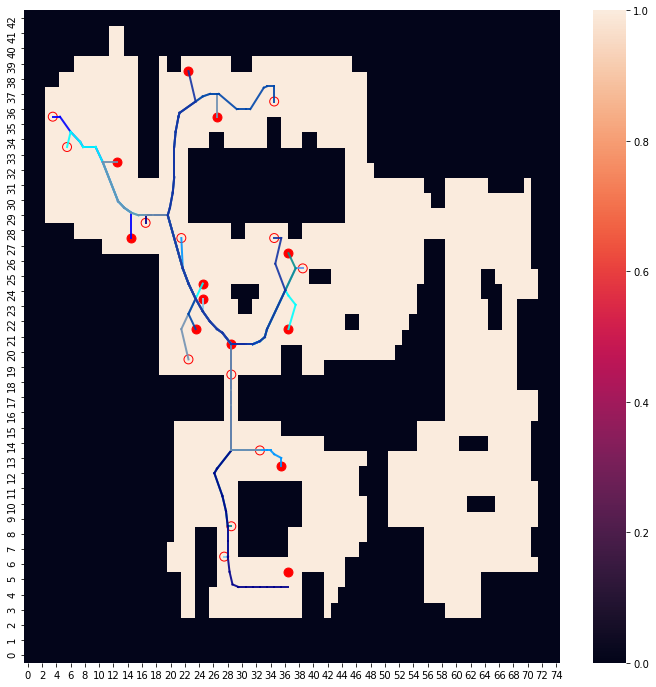

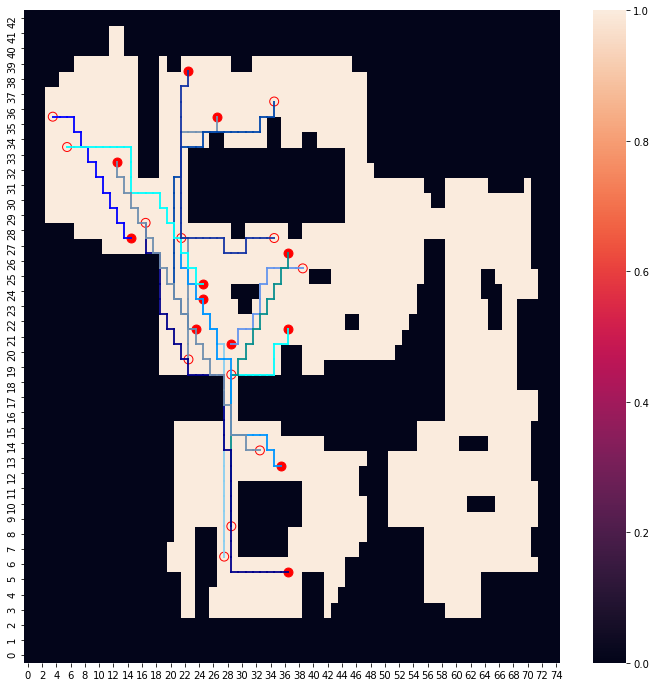

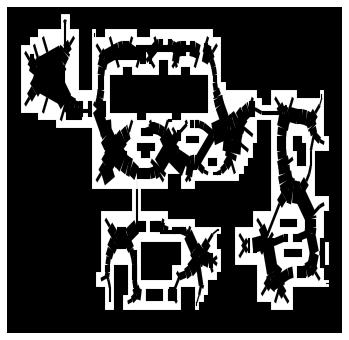

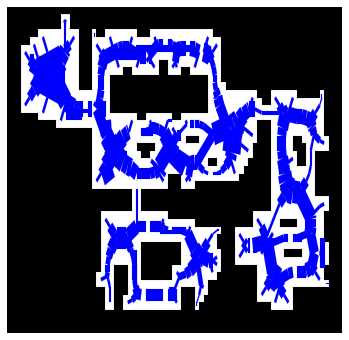

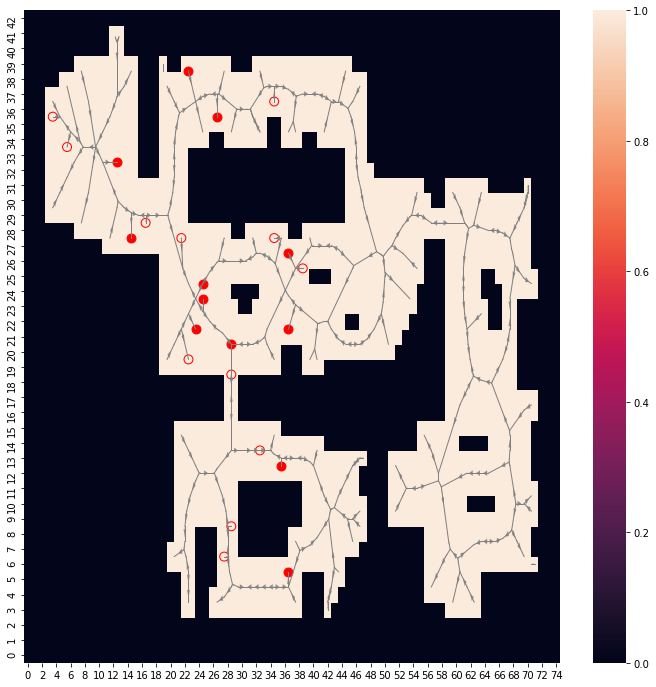

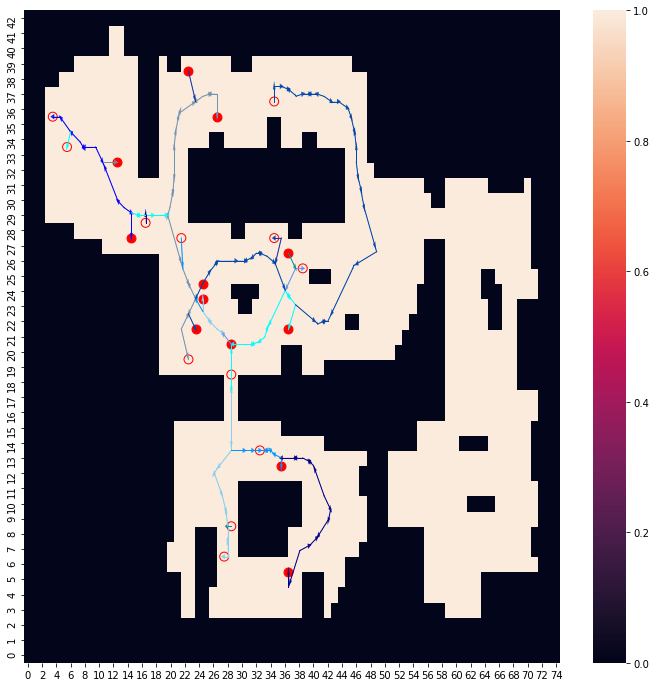

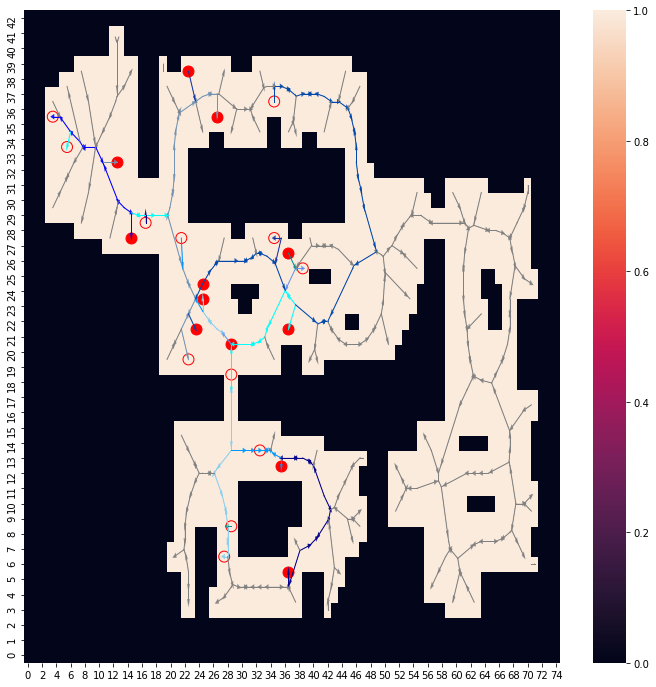

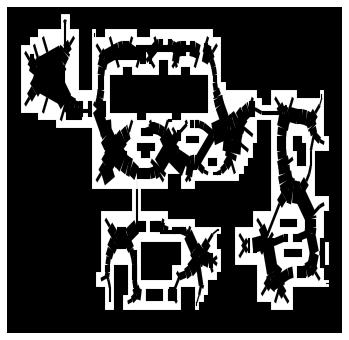

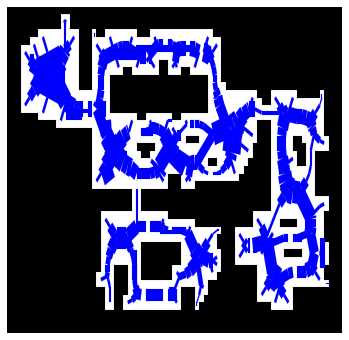

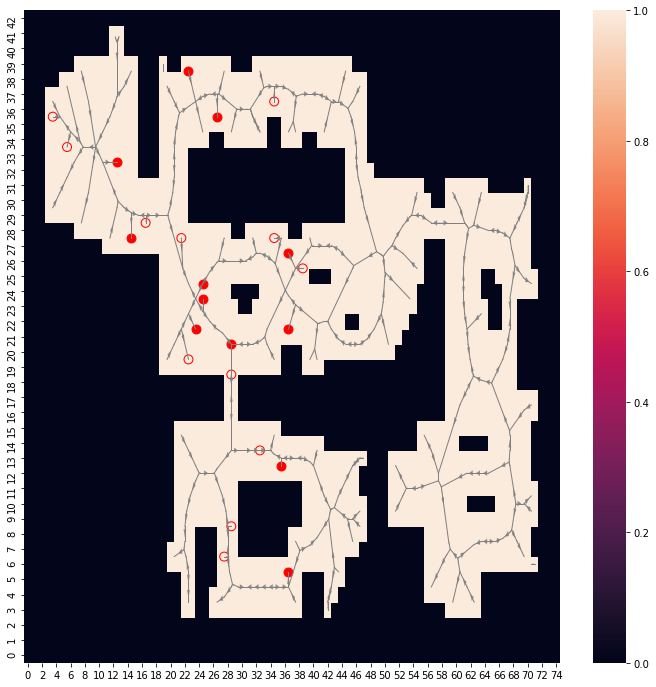

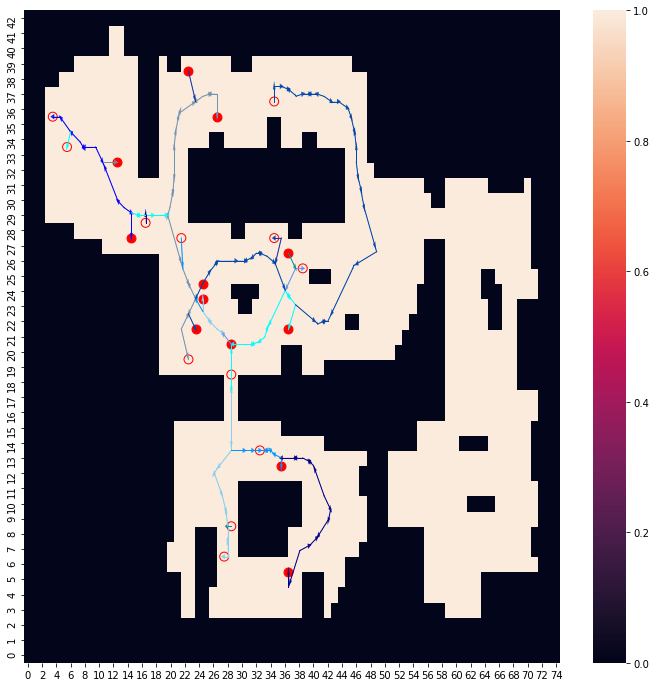

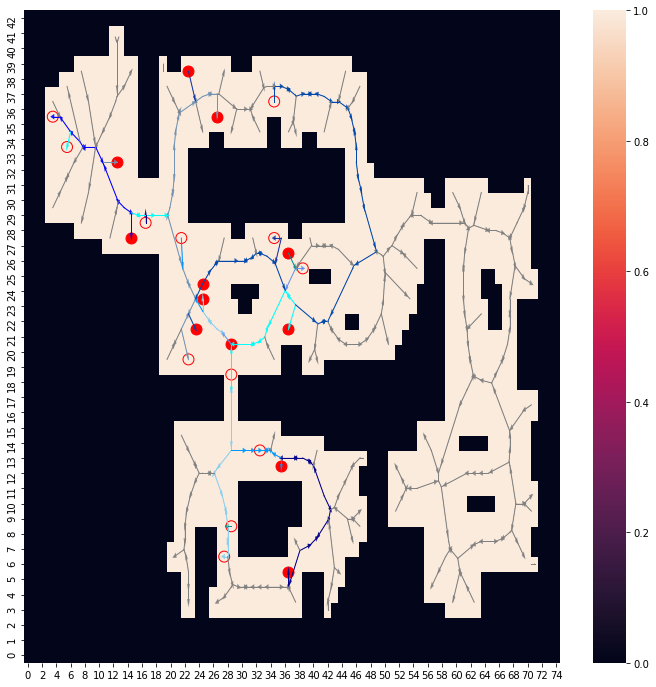

In [12]:
# num_agent_list = [2,4,6,8,10,12]
num_agent_list = [12]
objective_list = ["Distance","Capacity","Both"]
# objective_list = ["Capacity","Both"]
# maplist = ['den101d', 'lak105d', 'lak109d']
maplist = ['den101d']

final_result_path = "./data/same_density/final_result.csv"

for NUM_AGENT in num_agent_list:        
    for mapp in maplist:
        for DATASET in range(5,6,1):
            for obj_idx, OBJECTIVE in enumerate(objective_list):
                try:
                    overall_path = "./data/same_density/"+mapp+"/"+str(NUM_AGENT)+"-agent/objective-"+OBJECTIVE+"/Dataset"+str(DATASET)+"/"
                    os.makedirs(overall_path)
                except OSError:
                    print ("Creation of the directory %s failed" % overall_path)
                else:
                    print ("Successfully created the directory %s " % overall_path)

                grid_fig_path = overall_path+"grid.png"
                grid_path_path = overall_path+"grid.csv"
                vor_fig_path = overall_path+"vor.png"
                vor_path_path = overall_path+"vor.csv"
                vor_fig_coverage_path = overall_path+"vor_coverage.png"
                vordir_fig_pathonly_path = overall_path+"vordir_paths.png"
                vordir_fig_alledge_path = overall_path+"vordir_alledge.png"
                vordir_fig_acc_path = overall_path+"vordir_acc.png"
                vordir_fig_coverage_path = overall_path+"vordir_coverage.png"
                vordir_path_path = overall_path+"vordir_path.csv"
                vordir_probability_path = overall_path+"vordir_prob.csv"
                # without sub graph
                vordir2_fig_pathonly_path = overall_path+"vordir_nosub_paths.png"
                vordir2_fig_alledge_path = overall_path+"vordir_nosub_alledge.png"
                vordir2_fig_acc_path = overall_path+"vordir_nosub_acc.png"
                vordir2_fig_coverage_path = overall_path+"vordir_nosub_coverage.png"
                vordir2_path_path = overall_path+"vordir_nosub_path.csv"
                vordir2_probability_path = overall_path+"vordir_nosub_prob.csv"


                scene = "./input/same_density/"+ mapp +'/dataset/'+str(DATASET)+'_'+ mapp + ".scen"
                scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
                exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)

                # Voronoi
                vor_paths,vor_cost,vor_penality,vor_ft, vor_u1, vor_u2, vor_conwait, vor_conmax, vor_conavg, vor_G = expVoronoi.exp_voronoi(exp)
                assert exp.NUM_OF_AGENT == NUM_AGENT # raise error if cant find that many agent
#                 vor_conwait = getWaiting(paths=vor_paths, exp=exp)
                
                vor_u2 = getCoverage(exp,vor_G)
                getCoverage(exp,vor_G, save_fig_path=vor_fig_coverage_path) # save coverage plot
                _ = showVorSolution(
                    paths=vor_paths, 
                    graph=vor_G,
                    exp=exp, 
                    save_fig_path=vor_fig_path)
                with open(vor_path_path, 'a+') as f:
                    paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vor_paths) for t in path]
                    paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                    pd.DataFrame(paths_pd).to_csv(f, index=None)

                # Grid
                if obj_idx == 0:
                    grid_paths, grid_cost, grid_penality, grid_ft, grid_u1, grid_u2, grid_conwait, grid_conmax, grid_conavg = expGrid.exp_grid(exp)
                _ = showGirdSolution(paths = grid_paths, exp=exp, save_fig_path=grid_fig_path)
#                 grid_conwait = getWaiting(paths=grid_paths, exp=exp, grid = True)

                with open(grid_path_path, 'a+') as f:
                    paths = [[idx, t[0], t[1]] for idx, path in enumerate(grid_paths) for t in path]
                    paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                    pd.DataFrame(paths_pd).to_csv(f, index=None)


                # Directed Voronoi
                # Optimiser
                opt, graph = bo2VoronoiDirected.bo2_voronoi_directed(exp, num_sample = NUM_SAMPLE)
                vordir_m = opt.x_opt[-3]
                vordir_c = opt.x_opt[-2]
                # Visualisation
                probabilities = opt.x_opt
                output = bo2VoronoiDirected.get_results(probabilities, exp)
                vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conwait, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
#                 vordir_conwait = getWaiting(paths=vordir_paths, exp=exp)
                
                with open(vordir_path_path, 'a+') as f:
                    paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir_paths) for t in path]
                    paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                    pd.DataFrame(paths_pd).to_csv(f, index=None)
                with open(vordir_probability_path, 'a+') as f:
                    pd.DataFrame(opt.x_opt).to_csv(f, index=None)

                vordir_u2 = getCoverage(exp,vordir_G, directed = True)
                getCoverage(exp,vordir_G, directed = True, save_fig_path=vordir_fig_coverage_path)
                showVorDirSolution(vordir_G, vordir_paths, exp, save_fig_path = vordir_fig_alledge_path)
                showVorDirSolutionPath(vordir_G, 
                                        vordir_paths, 
                                        exp.image, 
                                        exp.nodes, 
                                        exp.start_nodes, 
                                        exp.end_nodes, 
                                        all_path = False, 
                                        path_num = 0,
                                        save_fig_path = vordir_fig_pathonly_path) #path_num variables is unused
                showVorDirSolutionAcc(vordir_G, 
                                        vordir_paths, 
                                        exp.image, 
                                        exp.nodes, 
                                        exp.start_nodes, 
                                        exp.end_nodes, 
                                        all_path = False, 
                                        path_num = 0,
                                        save_fig_path = vordir_fig_acc_path, 
                                        exp=exp)


                # Voronoi Directed Without subgraph
                probabilities2 = copy.deepcopy(probabilities)
                probabilities2[-1] = 0
                output2 = bo2VoronoiDirected.get_results(probabilities2, exp)
                vordir2_paths, vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_conavg, vordir2_G0, vordir2_G, vordir2_thres, vordir2_penality = output2
#                 print("vordir2_u1", vordir2_u1)
# vordir2_conwait = getWaiting(paths=vordir2_paths, exp=exp)
                
                vordir2_u2 = getCoverage(exp,vordir2_G0, directed = True)
                with open(vordir2_path_path, 'a+') as f:
                    paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir2_paths) for t in path]
                    paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                    pd.DataFrame(paths_pd).to_csv(f, index=None)
                with open(vordir2_probability_path, 'a+') as f:
                    pd.DataFrame(opt.x_opt).to_csv(f, index=None)
                getCoverage(exp,vordir2_G0, directed = True, save_fig_path=vordir2_fig_coverage_path)
                showVorDirSolution(vordir2_G0, vordir2_paths, exp, save_fig_path = vordir2_fig_alledge_path)
                showVorDirSolutionPath(vordir2_G0, 
                                        vordir2_paths, 
                                        exp.image, 
                                        exp.nodes, 
                                        exp.start_nodes, 
                                        exp.end_nodes, 
                                        all_path = False, 
                                        path_num = 0,
                                        save_fig_path = vordir2_fig_pathonly_path) #path_num variables is unused
                showVorDirSolutionAcc(vordir2_G0, 
                                        vordir2_paths, 
                                        exp.image, 
                                        exp.nodes, 
                                        exp.start_nodes, 
                                        exp.end_nodes, 
                                        all_path = False, 
                                        path_num = 0,
                                        save_fig_path = vordir2_fig_acc_path, 
                                        exp=exp)


                result = [mapp, NUM_AGENT, DATASET, OBJECTIVE, 
                          grid_ft, grid_u1, grid_conmax, grid_conavg, grid_conwait, grid_penality,
                          vor_ft, vor_u1, vor_u2, vor_conmax, vor_conavg, vor_conwait, vor_penality,
                          vordir_ft, vordir_u1, vordir_u2, vordir_conwait, vordir_penality,
                          vordir_conmax, vordir_conavg, vordir_thres, vordir_m, vordir_c,
                          vordir2_ft, vordir2_u1, vordir2_u2, vordir2_penality,
                          vordir2_conmax, vordir2_conavg, vordir2_conwait]

                # Saving results
                result_pd = pd.DataFrame([result],columns=[ 'Map', 'Agent', 'Dataset','Objective',
                                                            'grid_ft', 'grid_u1', 'grid_max', 'grid_avg', 'grid_conwait','grid_penality',
                                                            'vor_ft', 'vor_u1', 'vor_u2', 'vor_max', 'vor_avg', 'vor_conwait', 'vor_penality',
                                                            'vordir_ft', 'vordir_u1', 'vordir_u2','vordir_conwait', 'vordir_penality',
                                                            'vordir_max', 'vordir_avg', 'vordir_subgraph', 'vordir_m', 'vordir_c',
                                                            'vordir_ft_nosub', 'vordir_u1_nosub', 'vordir_u2_nosub', 'vordir_penality_nosub',
                                                            'vordir_max_nosub', 'vordir_avg_nosub', 'vordir_conwait_nosub'])

                with open(final_result_path, 'a+') as f:
                    pd.DataFrame(result_pd).to_csv(f, index=None)

                results.append(result)
    

In [11]:
df = pd.DataFrame(results,columns=[ 'Map', 'Agent', 'Dataset','Objective',
                                    'grid_ft', 'grid_u1', 'grid_max', 'grid_avg', 'grid_conwait','grid_penality',
                                    'vor_ft', 'vor_u1', 'vor_u2', 'vor_max', 'vor_avg', 'vor_conwait', 'vor_penality',
                                    'vordir_ft', 'vordir_u1', 'vordir_u2','vordir_conwait', 'vordir_penality',
                                    'vordir_max', 'vordir_avg', 'vordir_subgraph', 'vordir_m', 'vordir_c',
                                    'vordir_ft_nosub', 'vordir_u1_nosub', 'vordir_u2_nosub', 'vordir_penality_nosub',
                                    'vordir_max_nosub', 'vordir_avg_nosub', 'vordir_conwait_nosub'])

In [13]:
df

,Map,Agent,Dataset,Objective,grid_ft,grid_u1,grid_max,grid_avg,grid_conwait,grid_penality,...,vordir_subgraph,vordir_m,vordir_c,vordir_ft_nosub,vordir_u1_nosub,vordir_u2_nosub,vordir_penality_nosub,vordir_max_nosub,vordir_avg_nosub,vordir_conwait_nosub
0,den101d,2,1,Distance,0.625000,0.002082,1.0,0.044444,0.0,19.384776,...,0.347366,-0.402493,0.399180,3.316611,0.002355,0.194242,0.0,1.0,0.044444,2.500
1,den101d,2,1,Capacity,0.625000,0.002082,1.0,0.044444,0.0,19.384776,...,0.453737,-0.357864,0.522736,3.316611,0.002355,0.194242,0.0,1.0,0.044444,2.500
2,den101d,2,1,Both,0.625000,0.002082,1.0,0.044444,0.0,19.384776,...,0.411821,-0.353411,0.403546,3.316611,0.002355,0.194242,0.0,1.0,0.044444,2.500
3,lak105d,2,1,Distance,0.625000,0.006631,2.0,0.166667,0.0,5.123106,...,0.352952,-0.386793,0.701275,4.405634,0.011774,0.168935,0.0,2.0,0.166667,5.500
4,lak105d,2,1,Capacity,0.625000,0.006631,2.0,0.166667,0.0,5.123106,...,0.461298,-0.277491,0.555316,4.405634,0.011774,0.168935,0.0,2.0,0.166667,5.500
5,lak105d,2,1,Both,0.625000,0.006631,2.0,0.166667,0.0,5.123106,...,0.158161,0.255440,0.614950,4.405634,0.011774,0.168935,0.0,2.0,0.166667,5.500
6,lak109d,2,1,Distance,0.500000,0.005587,1.0,0.100000,0.0,17.556349,...,0.426374,0.106985,0.406000,3.622014,0.009126,0.128783,0.0,1.0,0.100000,3.000
7,lak109d,2,1,Capacity,0.500000,0.005587,1.0,0.100000,0.0,17.556349,...,0.435761,-0.159739,0.507403,3.622014,0.009126,0.128783,0.0,1.0,0.100000,3.000
8,lak109d,2,1,Both,0.500000,0.005587,1.0,0.100000,0.0,17.556349,...,0.415583,0.338771,0.335629,3.622014,0.009126,0.128783,0.0,1.0,0.100000,3.000
9,den101d,4,1,Distance,0.500000,0.003332,1.0,0.088889,0.0,80.117033,...,0.208972,-0.223425,0.512814,3.080111,0.004329,0.192911,0.0,1.0,0.088889,3.000
